<a href="https://colab.research.google.com/github/AndreasMing/Learning/blob/main/NeuralnetsWithMicrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural nets with micrograd
This is a Notebook to the free lecture [The spelled-out intro to neural networks and backpropagation: building micrograd](https://youtu.be/VMj-3S1tku0) by [Andrey Karpathy](https://github.com/karpathy).

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Understanding the derivativ

## Derivative of a function with a single input

$$3x^2 - 4x + 5$$

In [3]:
def f(x):
  return 3*x**2 - 4*x +5

In [5]:
f(3.0)

20.0

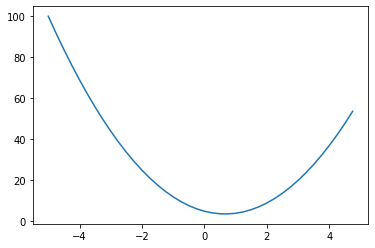

In [8]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

Normally derivatives are derived directly from the mathematical expression of the base function. This is not done with neural networks. The fundemental definition of a derivative is stated as follows:

$$\frac{dy}{dx} = \lim_{h\to 0}\frac{f(x+h) - f(x)}{h}$$

By knowing this, the derivative can be derived by changeing the input by a small amount. Per definition the step of $h$ would be infinitly small.


In [15]:
h = 0.001
x = 3.0         # derviative at this point
print('x = ', x, ' h = ', h)
print('f(x) = ', f(x))
print('f(x + h) = ', f(x + h))
print('dy/dx = ', (f(x+h)-f(x))/h)

x =  3.0  h =  0.001
f(x) =  20.0
f(x + h) =  20.014003000000002
dy/dx =  14.00300000000243


## Derivative of a function with multiple inputs
Functions with a single input are fairly easy to derive mathematically, this changes with functions with multiple inputs and neural nets have many of them.

In [21]:
h = 0.001

# inputs (Point of derivation)
a = 2.0
b = -3.0
c = 10.0

# function
def f(a, b, c):
 return a*b + c

# derive
d1 = f(a, b, c)
print('d1 = ', d1)
c += h              # with respect to
d2 = f(a, b, c)
print('d2 = ', d2)
print('slope = ', (d2-d1)/h)

d1 =  4.0
d2 =  4.0009999999999994
slope =  0.9999999999994458


# Value class in micrograd

Micrograd provides a class *Value* for easy implementation and tracking of neural propagation. It initialy behaves as a normal scalar.

* Attribute ``data`` consists of the scalar value
* ``_prev`` provides a linked list along all of the operations
* ``_op`` stores the operation which lead to this node
* ``label`` is for visualization and documentation purposes for the function ``draw_dot()`` later on
* ``grad`` is the derivative in respect to a inputchange

**``grad``** describes how the output of a linked list of operations changes with the changes of the value of the corresponding node. The determination of these values is called **backpropagation**.



In [50]:
class Value:

  def __init__(self, data, _children=(), _op='', label = ''):# provide values for the attributes at runtime
    self.data = data
    self.grad = 0.0                 # affection of this value to the output
    self._prev = set(_children)     # children variable keeps track of the values
                                    # which lead to this result
    self._op = _op                  # keeps track of the operations
    self.label = label              # for visualization purposes

  def __repr__(self):             # overwrites the standard return of the object
    return f"Value(data={self.data})"

  def __add__(self, other):       # what to do if two value objects are added
    return Value(self.data + other.data, (self, other), '+')

  def __mul__(self, other):       # what to do if two value objects are multiplied
    return Value(self.data * other.data, (self, other), '*')

In [52]:
# testing
a = Value(3.0, label = 'a')
b = Value(-5.0, label = 'b')
c = Value(10.0, label = 'c')
d = a*b; d.label = 'd'
e = d+c; e.label = 'e'
f = Value(3.2, label = 'f')
L = e*f; L.label = 'L'
print('L: \t', L)
print('_prev:\t', L._prev)
print('_op: \t', L._op)

L: 	 Value(data=-16.0)
_prev:	 {Value(data=-5.0), Value(data=3.2)}
_op: 	 *


## Vizualisation
See [Sourcecode](https://github.com/karpathy/micrograd/blob/master/trace_graph.ipynb)

In [45]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

$a$ and $b$ are acting as node inputs, where as $c$ to $f$ act as the weights within the neural net. $grad$ describes how a valuechange of the corresponding node is influencing the output value.

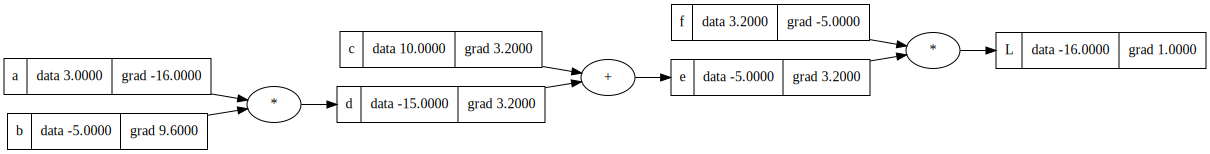

In [59]:
draw_dot(L)

## Determination of grad

### Manual backpropagation example #1: simple expression

First of we are going to determine the grad values by manual backpropagation:

* $grad$ of $L$ will always be $1.0$ because we are calculating $\frac{dL}{dL} = 1$
* $e.gard = \frac{dL}{de} = \frac{d}{de}f*e = f$
* $f.gard = \frac{dL}{df} = \frac{d}{df}f*e = e$

*local derivative of the **Sum**-node, because we already know how $e$ is impacting $L$:*
* calculate $\frac{de}{dc} = \frac{d}{dc}c+d = 1$
* and by symmetry $\frac{de}{dd} = 1$

by applying the chainrule: **(Sum-nodes routes the derivative from the upper node to the two adjoining values)**
* $c.grad = \frac{dL}{dc} = \frac{dL}{de} * \frac{de}{dc} = e.grad * 1 = e.grad$
* $d.grad = \frac{dL}{dd} = \frac{dL}{de} * \frac{de}{dd} = e.grad * 1 = e.grad$

*local gradient of **Times**-node: (likewise as on the first node*
* $a.gard = \frac{dd}{da} = \frac{d}{da}a*b = b$
* $b.gard = \frac{dd}{db} = \frac{d}{db}a*b = a$

by appying the chainrule:
* $a.grad = \frac{dL}{da} = \frac{dL}{dd} * \frac{dd}{da} = d.grad * b$
* $b.grad = \frac{dL}{db} = \frac{dL}{dd} * \frac{dd}{db} = d.grad * a$

In [58]:
L.grad = 1
e.grad = f.data
f.grad = e.data
c.grad = e.grad
d.grad = e.grad
a.grad = d.grad * b.data
b.grad = d.grad * a.data
